## Set up Python libraries

As usual, run the code cell below to import the relevant Python libraries

In [1]:
# Set-up Python libraries - you need to run this but you don't need to change it
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas 
import seaborn as sns

# Non parametric tests

This week we are looking at non-parametric equivalents of the t-test.

The t-test is valid only when the data within each group (for independent samples t-test) or the pairwise differences (for paired samples t-test) are Normally distributed

As we have seen in the lecture, many real life data distributions are normal, but many others are not.

For non-Normal data we can use non-parametric tests, which do not assume that the data are drawn from a Normal distribution.

# The Mann Whitney U, or Wilcoxon Rank Sum Test

This is a test for a difference in median between two independent samples. As such it is often considered to be a non-parametric equivalent for the independent samples t-test.

The terms Mann Whitney U and Wilcoxon Rank Sum are used interchangeably in a lot of literature and statistical packages, although technically the Mann Whitney version, which came slightly later, is correct in a greater range of cases. 

The Python function we will use is called Mann-Whitney but you will see the same test elsewhere called Rank Sum or Wilcoxon Rank Sum.

## Example: Mann Whitney or Wilcoxon Rank Sum test

A researcher hypothesises that when a person learns a new motor skill, imaginary practice (visualising performing the skill between sessions of actual practice) can enhance learning.

She decides to test the hypothesis by training people to juggle. The participants complete 1-hour juggling practice sessions each day until they can juggle for 2 minutes without dropping a ball. Participaants are randomly assigned to one of two groups: The Visualisation Group spend time between sessions visualising juggling, whilst the Standard Group do not.

The researcher records the number of sessions taken to reach criterion (2 min juggling without dropping the ball) for each participant.

Test the hypothesis that visualisation reduces the number of sessions required to reach criterion.

### Inspect the data

The data are provided in a text (.csv) file.

Let's load the data as a Pandas dataframe, and plot them to get a sense for their distribution (is it normal?) and any outliers

In [2]:
# load the data and have a look
pandas.read_csv('data/juggling.csv')

,Group,SessionsToCriterion
0,Standard,15
1,Standard,14
2,Standard,15
3,Standard,8
4,Standard,7
5,Standard,22
6,Standard,36
7,Standard,19
8,Standard,14
9,Standard,18


You might notice the strange term NaN in a couple of cells of the table.

This stands for "Not a Number" and in this case just represents a missing value - there were two fewer people in the visualisation group than the standard training group

Let's plot the data and see if they look Normally distributed.

As we saw in the session on plotting, a good choice here will be a KDE plot (to get an estimate of the shape of the distribution) and a rug plot (individual data values as the KDE plot is based on only a small sample)

/var/folders/q4/twg1yll54y142rc02m5wwbt40000gr/T/ipykernel_59029/2016210674.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(juggling_Std['SessionsToCriterion'], color='b', shade=True, label='Standard Training')
/var/folders/q4/twg1yll54y142rc02m5wwbt40000gr/T/ipykernel_59029/2016210674.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(juggling_Vis['SessionsToCriterion'], color='r', shade=True, label='Visualisation Training')


Text(0, 0.5, 'Density')

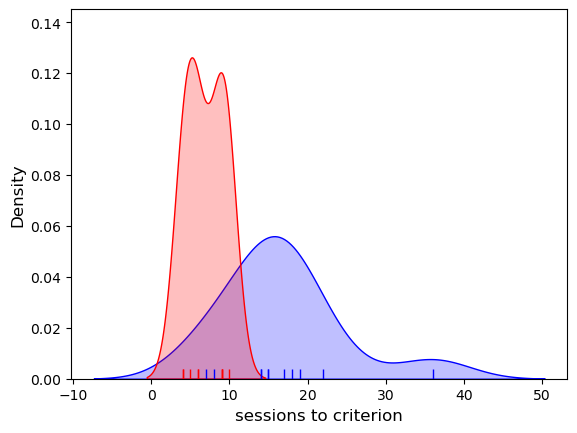

In [3]:
juggling = pandas.read_csv('data/juggling.csv')

# make new dataframes for the Standard and Visualisation groups
juggling_Std = juggling[juggling['Group']=='Standard']
juggling_Vis = juggling[juggling['Group']=='Visualisation']

# Plot the KDE (distribution)
sns.kdeplot(juggling_Std['SessionsToCriterion'], color='b', shade=True, label='Standard Training')
sns.kdeplot(juggling_Vis['SessionsToCriterion'], color='r', shade=True, label='Visualisation Training')

# Plot individual data points
sns.rugplot(juggling_Std['SessionsToCriterion'], color='b')
sns.rugplot(juggling_Vis['SessionsToCriterion'], color='r')

# axis labels
plt.xlabel("sessions to criterion", fontsize = 12)
plt.ylabel("Density", fontsize = 12)

The data do not look normal, as some people (especially in the standard group) took much longer to reach criterion (the distribution has positive skew).

Even if the data were not grossly non-Normal, it would be hard to be confident of a normal distribution with such a small sample, unless there waas some theoretical reason (for example, relating to the Central Limit Theorem) why the data should be normal. In this case, we might even have expected a positive skew as it is possible for an individual to take maany many more than the median number of sessions to reach criterion, but impossible to take many many fewer sessions (as we cannot take fewer than zero sessions; data values are <i>bounded below</i>).

We therefore turn to the Mann Whitney non-parametric test.

### Hypotheses

Ho: the <b>median</b> number of sessions needed is the same for participants in the Visualisation and Standard Groups

Ha: the <b>median</b> number of sessions is lower for participants in the Visualisation Group
    
This is a one tailed test as the hypothesis is directional (we expect visualisation to help not hinder)

We will test at the $\alpha = 0.05$ significance level

<ul>
    <li> note we are testing for a difference of mediaans here, not a difference of means as in the t-test
</ul>

### Descriptive statistics

We obtain the relevant descriptive statistics. For the t-test we reported the summary statistics (mean, s.d. and n) that went into the formula for t. The same approach won't quite work here as the test is not based on summary statistics. However, common sense suggests that reporting the median for each group, a measure of spread, and the sample size woudl give the reader an idea of the data.

In [4]:
juggling.groupby(['Group']).describe()

SessionsToCriterion                                              \
                            count       mean       std  min   25%   50%   75%   
Group                                                                           
Standard                     11.0  16.818182  7.730694  7.0  14.0  15.0  18.5   
Visualisation                 9.0   6.888889  2.368778  4.0   5.0   6.0   9.0   

                     
                max  
Group                
Standard       36.0  
Visualisation  10.0

The median number of sessions to criterion is lower in the Visualisation Group (median=6, q1=5, q3=9, n=9) than the Standaard Group (median=15, q1=14, q3=18.5, n=11) 

### Carry out the test

We carry out the test using the function <tt>mannwhitneyu</tt> from <tt>scipy.stats</tt>, here loaded as <tt>stats</tt>

In [5]:
stats.mannwhitneyu(juggling.loc[(juggling['Group']=='Standard'),'SessionsToCriterion'], 
                   juggling.loc[(juggling['Group']=='Visualisation'),'SessionsToCriterion'],
                   alternative='greater')

MannwhitneyuResult(statistic=91.0, pvalue=0.0008910429856493874)

The inputs to stats.mannwhitneyu are:
<ul>
    <li >the two samples to be compared (the values of <tt>SessionsToCriterion</tt> from our Pandas data frame <tt>juggling</tt>), grouped by the value in the column <tt>Group</tt>)
<li>the argument <tt>alternative='greater'</tt>, which tells the computer to run a one tailed test 
that mean of the first input (Standard Group) is greater than the second (Visualisation Group).
</ul>
    
The outputs are a value of the test statistic ($U=91$) and <tt>pvalue</tt> ($p=0.00089$) - if this is less than our $\alpha$ value 0.5, there is a significant difference.

More explanation of how U is calculated below.

### Draw conclusions

As the p value of 0.00089 is less than our alpha value of 0.05, the test is significant. 

We can conclude that the median number of sessions to criterion is indeed greater in the Standard training group

## How the Mann Whiney U or Wilcoxon Rank Sum test works

You have seen how to carry out the Mann Whitney test using <tt>scipy.stats</tt> but you may be none the wiser about how the computer arrived at the test statistic and p value.

In this section we will build our own version of the test step by step to understand how it worked.

### Step 1: Convert the data to ranks

As seen in the lecture, the key step in the Mann Whitney test is to replace the data with their ranks. 

We will then obtain a summary statistics U (closely related to R in the rank sum test) which roughly tells us what proportion of the high ranks fall into one experimental group.

The null distribution of U (or R) is the same for any samples of given size (in this case our samples are $n_1=11$ and $n_2=9$ - the null distribubtion of U would be the same for <i>any data</i> with these sample sizes

Note also that data ranks are less affected by outliers than the data values themselves: whether the lowest data value is a million units lower than the second-lowest data value, or only one unit lower, they will still take ranks 1 and 2.

We can rank the data using the <tt>rank</tt> method in <tt>pandas</tt>

In [6]:
juggling['SessionsToCriterion'].rank()

0     14.5
1     12.5
2     14.5
3      7.0
4      6.0
5     19.0
6     20.0
7     18.0
8     12.5
9     17.0
10    16.0
11     9.0
12     1.5
13     9.0
14    11.0
15     4.5
16     4.5
17     1.5
18     3.0
19     9.0
Name: SessionsToCriterion, dtype: float64

Let's make that more user friendly by saving it as an additional column in out dataframe

In [7]:
juggling['Rank'] = juggling['SessionsToCriterion'].rank()
juggling

,Group,SessionsToCriterion,Rank
0,Standard,15,14.5
1,Standard,14,12.5
2,Standard,15,14.5
3,Standard,8,7.0
4,Standard,7,6.0
5,Standard,22,19.0
6,Standard,36,20.0
7,Standard,19,18.0
8,Standard,14,12.5
9,Standard,18,17.0


It might be even clearer if we display the dataframe sorted by rank

In [8]:
juggling.sort_values('Rank')

,Group,SessionsToCriterion,Rank
17,Visualisation,4,1.5
12,Visualisation,4,1.5
18,Visualisation,5,3.0
16,Visualisation,6,4.5
15,Visualisation,6,4.5
4,Standard,7,6.0
3,Standard,8,7.0
19,Visualisation,9,9.0
13,Visualisation,9,9.0
11,Visualisation,9,9.0


Note the following:
<ul>
<li> The lowest value has rank 1
<li> The highest value has rank $n_1 + n_2$, ie the total number of data points across both groups together
<li> Tied values are given the average of the ranks they would have got (ranks 1 and 2 are tied so both get 1.5)
<li> Many of the higher ranked values are in the Standard group, hinting that most of the slowest participants to reach criterion were in the Standard Group
<li> Many of the lower ranked values are in the Visualisation group, hinting that most of the fastest participants to reach criterion were in the Visualisation Group

### Calculate the test statistic

The test statistic is the larger of $U_1$ and $U_2$, given by 

$$ U_1 = R_1 - \frac{n_1(n_1+1)}{2}$$

Where $R_1$ is the sum of all the ranks in group 1, and $n_1$ is the size of group 1

and

$$ U_2 = R_2 - \frac{n_2(n_2+1)}{2}$$

We can work it out in Python:

In [9]:
# Sum of ranks for group 1 - find the rows where group is 'Standard', select column 'Rank', and sum() the values 
R1 = juggling.loc[(juggling['Group']=='Standard'),'Rank'].sum()
# Get n for group 1 - find the rows where group is 'Standard', select column 'Rank', and count() the values 
n1 = juggling.loc[(juggling['Group']=='Standard'),'Rank'].count()

# calculate U from the formula
U1 = R1 - (n1*(n1+1))/2
print('U1 = ' + str(U1))

U1 = 91.0


In [10]:
# Sum of ranks for group 1 - find the rows where group is 'Standard', select column 'Rank', and sum() the values 
R2 = juggling.loc[(juggling['Group']=='Visualisation'),'Rank'].sum()
# Get n for group 1 - find the rows where group is 'Standard', select column 'Rank', and count() the values 
n2 = juggling.loc[(juggling['Group']=='Visualisation'),'Rank'].count()

# calculate U from the formula
U2 = R2 - (n2*(n2+1))/2
print('U2 = ' + str(U2))

U2 = 8.0


The larger of $U_1$ and $U_2$ becomes the test statistic, so $U=91$

<ul>
    <li> Go back and check if this matches what we got from <tt>scipy.stats.mannwhitneyu</tt> - it should!
</ul>

(some stats packages define $U$ as the smaller of $U_1$ and $U_2$, confusingly - either could be used but the null distribtion for the larger and smaller U will obviously be different)

### Establish the null distriubtion

To convert our $U$ to a $p$-value, we need to know how the probability of obtaining that value of $U$ due to chance if the null hypothesis were true.

More precisely:

<ul> 
    <li> If the value we have chosen as $U$ is associated with the sample we expect to have higher ranks, we need to know the probability of getting a $U$ value this large or larger, if the null were true
    <li> Conversely if the value we have chosen as $U$ is associated with the sample we expect to have lower ranks, we need to know the probabbility of getting a $U$ value this small or smaller, if the null were true
</ul>

In the current example, $U$ ended up being the $U$ value for the Standard training regime, which we expected to have more of the higher ranks (more of the people who needed longer to reach the criterion for fluent juggling).

So we are looking for the probability of obtaining $U>=91$ if the null were true.

### What do we mean by "If the null were true"?

If the null were true, participants should on average need the same number of sessions to reach the criterion of 2 min juggling, regardless of whether they were in the Visualisation condition or the Standard Condition. It could still happen that the Standard Group got a lot of high ranks (and hence a high value of $U$) by chance, but as we get to higher values of $U$, that becomes less and less likely.

So if the null were true, high and low ranks would occur randomly in the Standard and Visualisation groups. So the possible ranks (in this case, the numbers 1-20 as $n_1 + N_2 = 20$) could be deal out randomly into the two groups.


### Estalbishing the null by complete enumeration

For a much smaller sample size, we could work out all the possible ways the ranks could be randomly dealt into the Standard and Visualisation groups, calculate $U$ for each case, and work out in what proportion of cases this <i>simulated</i> $U$ was as large as, or larger than, the value of $U$ from our experiment.

This is not practical for larger samples as there are too many possible ways to deal the ranks (too many <i>combbinations</i>). In the example above where $n_1 = 9$ and $n_2 = 11$, the number of possible deals or combinations is 167960 - for larger $n$ the number of combinations becomes astronomical.

### Establishing the null by simulation

We can work out the null approximately by doing a lot of random 'deals' of the ranks to the Standard and Visualisation groups, calculating $U$ for each case, and work out in what proportion of cases this <i>simulated</i> $U$ was as large as, or larger than, the value of $U$ from our experiment.

"A lot" might be 10,000 or more (this is still much lower than the number of possible deals under complete enumeration)

Let's try it!

In [11]:
# Possible ranks are the numbers 1 to 20 (remember Python uses the counterintuitive syntax [1,21))
ranks = np.arange(1,21)
ranks

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

In [12]:
# Shuffle them!
np.random.shuffle(ranks)
ranks

array([14,  7,  5, 19,  1,  2, 10,  4, 11, 20, 16,  8, 13, 17,  3, 15, 12,
        6,  9, 18])

In [13]:
# R1 is the sum of the first 11 ranks
R1 = ranks[0:11].sum()
R1

109

In [14]:
# Calculate U1
n1 = 11
U1 = R1 - (n1*(n1+1))/2
U1

43.0

In [15]:
# R2 is the sum of the rest of the ranks
R2 = ranks[11:].sum()
R2

101

In [16]:
# Calculate U2
n2 = 9
U2 = R2 - (n2*(n2+1))/2
U2

56.0

In [17]:
# U is the larger of U1 and U2
U = max(U1, U2)
U

56.0

Phew! That was on random 'deal' or shuffle, resulting in a $U$ value of 52.

Now we need to make a loop to do that 10,000 times!

In [18]:
n1 = 11
n2 = 9
n = n1+n2
ranks = np.arange(1,(n+1))
maxR = ranks[min(n1,n2):].sum()
maxU = maxR - (max(n1,n2)*(max(n1,n2)+1))/2
maxU = int(maxU)

nReps = 10000
simulated_U = np.empty(nReps)

for i in range(nReps):
    np.random.shuffle(ranks)
    
    R1 = ranks[0:n1].sum()
    U1 = R1 - (n1*(n1+1))/2
   
    R2 = ranks[0:n2].sum()
    U2 = R2 - (n2*(n2+1))/2
    
    U = max(U1, U2)
    simulated_U[i] = U

freq = np.empty(maxU+1)

for j in np.arange(maxU):
    freq[j] = np.count_nonzero(simulated_U == j)

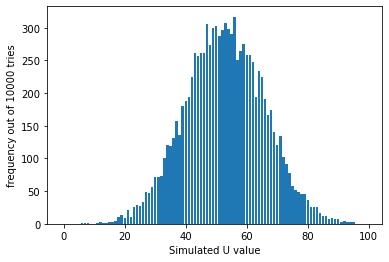